# Deep Learning Project: Image Super-Resolution

```
Course Instructor: 
+ Nikos Deligiannis
Teaching Assistants:
+ Lusine Abrahamyan
+ Giannis Bekoulis

Student Group:
+ Esteban Velásquez Rendón
+ Andrzej Krzysztof Pietrusiak
+ Amna Jouini

MSc. Applied Computer Science 2021-2022
```

### Description
Super-resolution from a single low-resolution image has always been an ill-posed
problem. The current state of the art consists in training a convolutional  neural network with a large dataset of natural-looking images. Corresponding
low-resolution images are computed and fed as an input to the neural network. The learned feature maps have been shown to produce less artefacts than classical
methods.

Notes:
* The image is represented using a three-dimensional tensor in
order to preserve its spatial structure. Two dimensions in the tensor correspond to the spatial dimensions in the image and the tensor ‘depth’ corresponds to
the image ‘depth’ (image colour channels).
* Filter and image have the same depth
* 

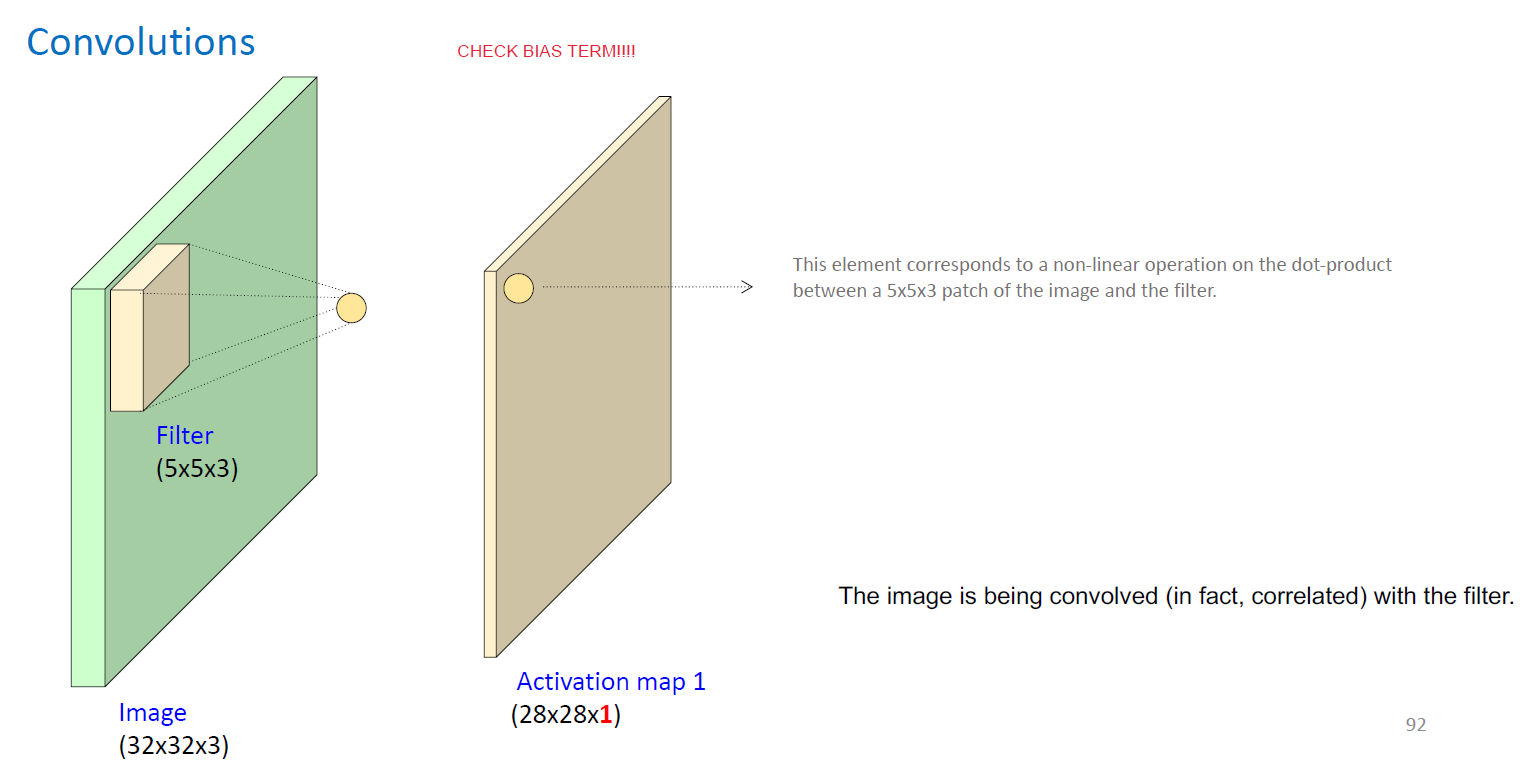

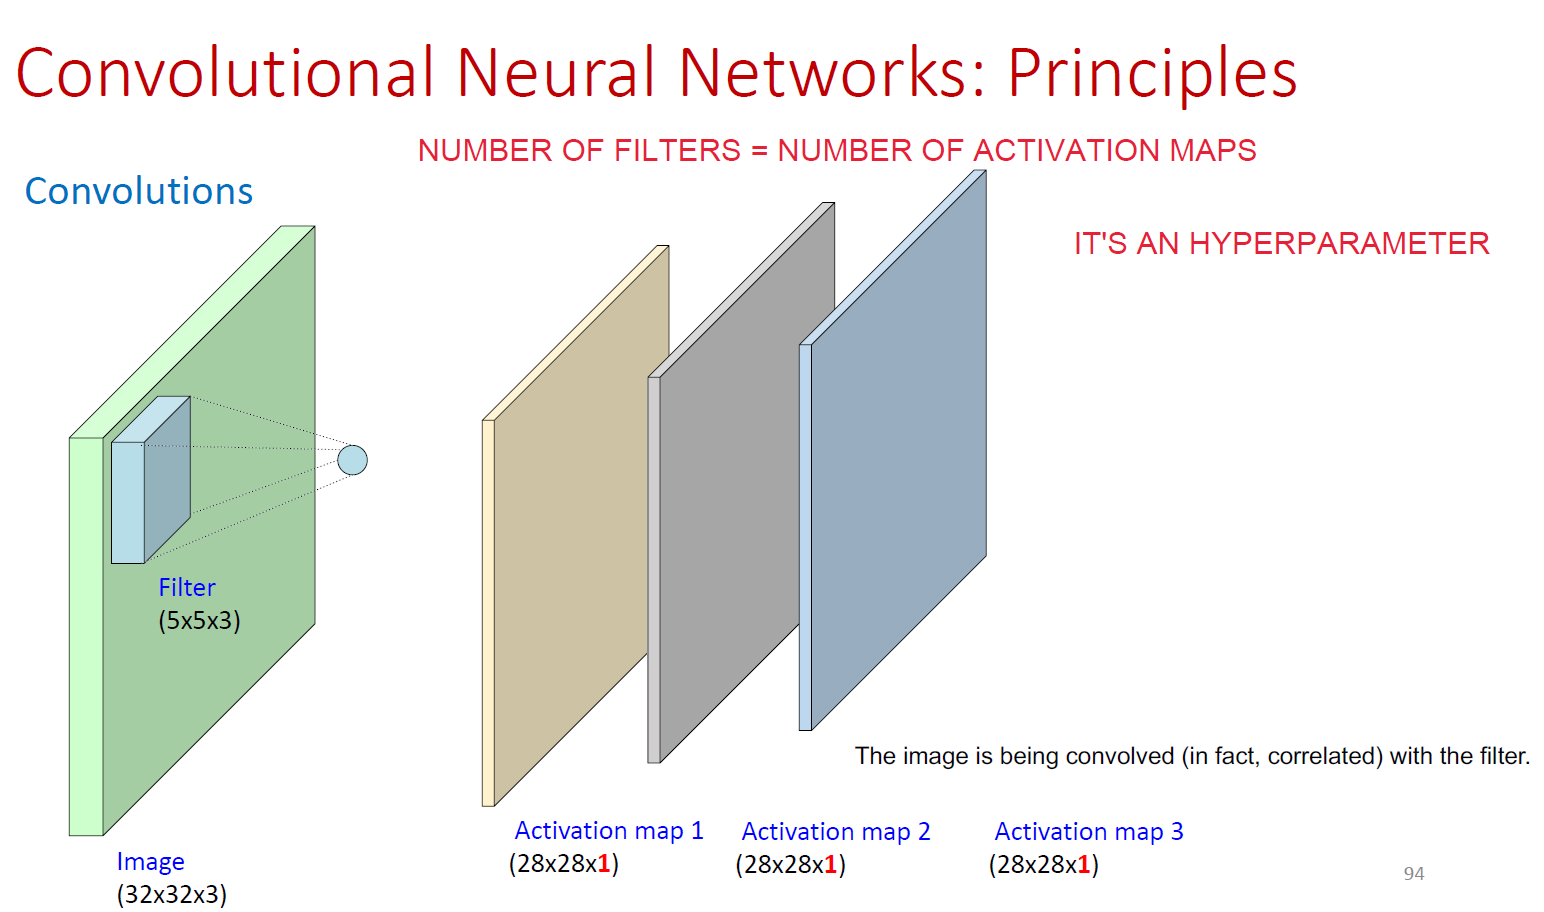

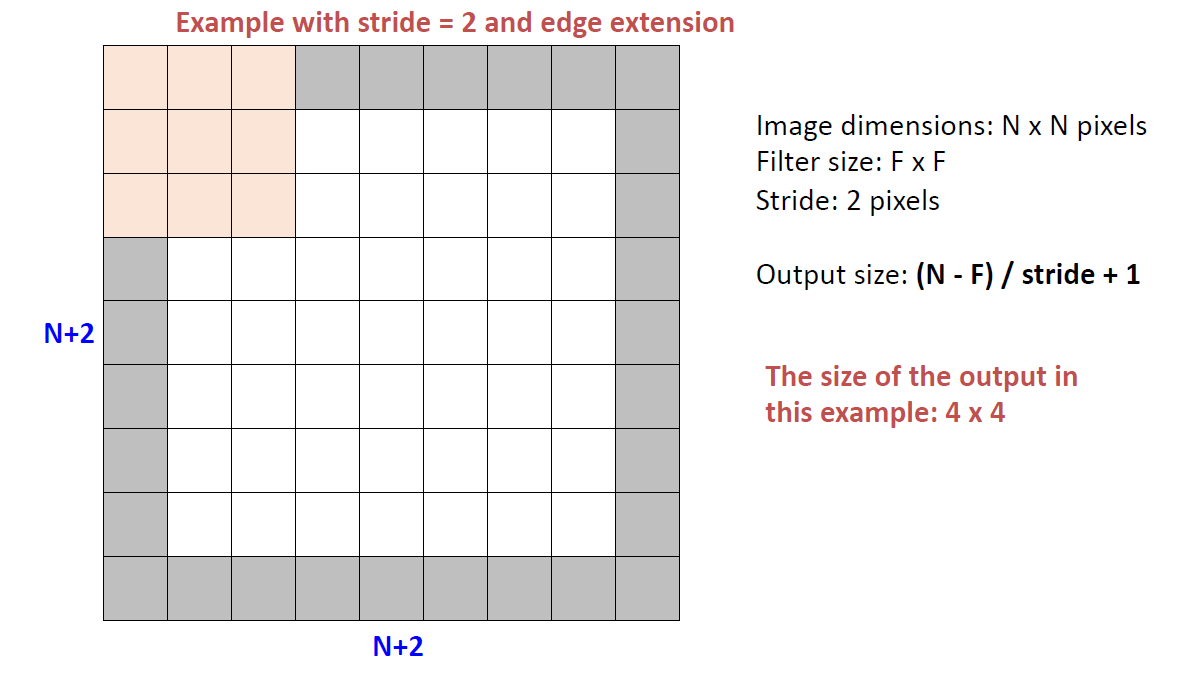

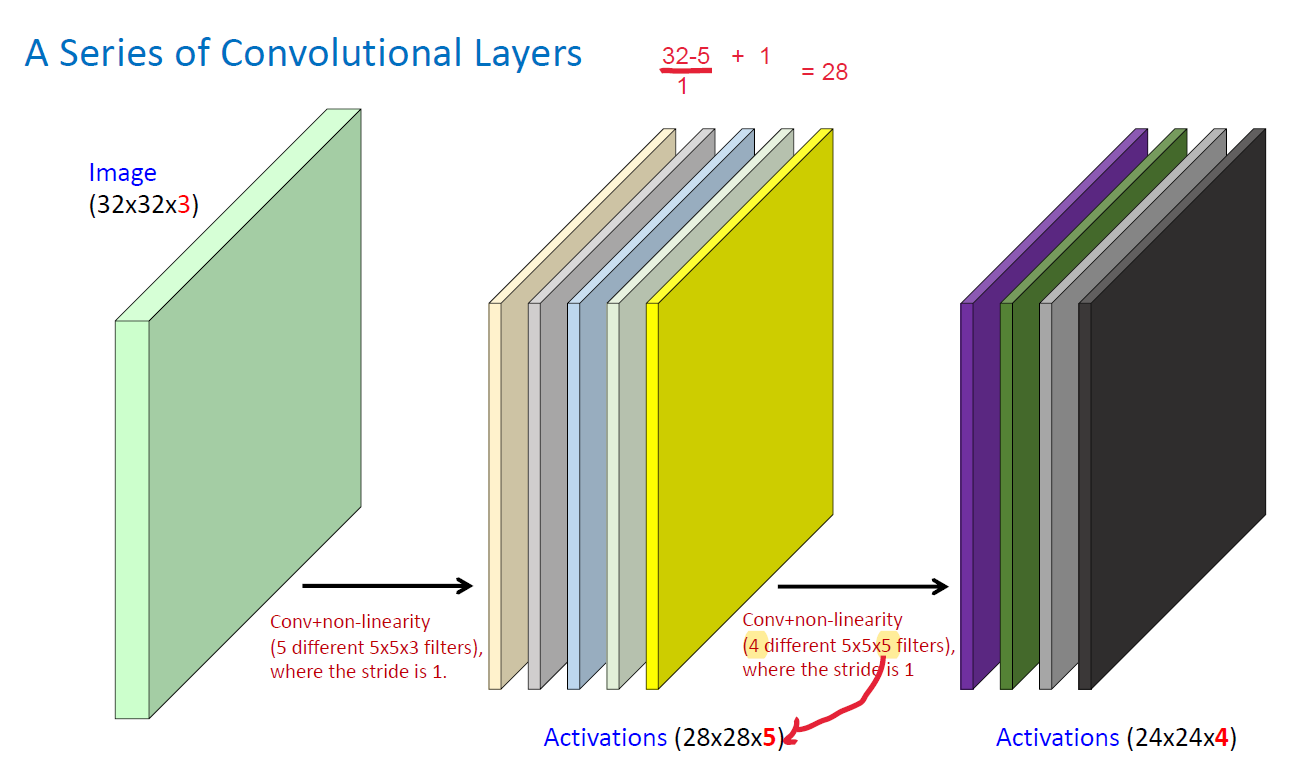

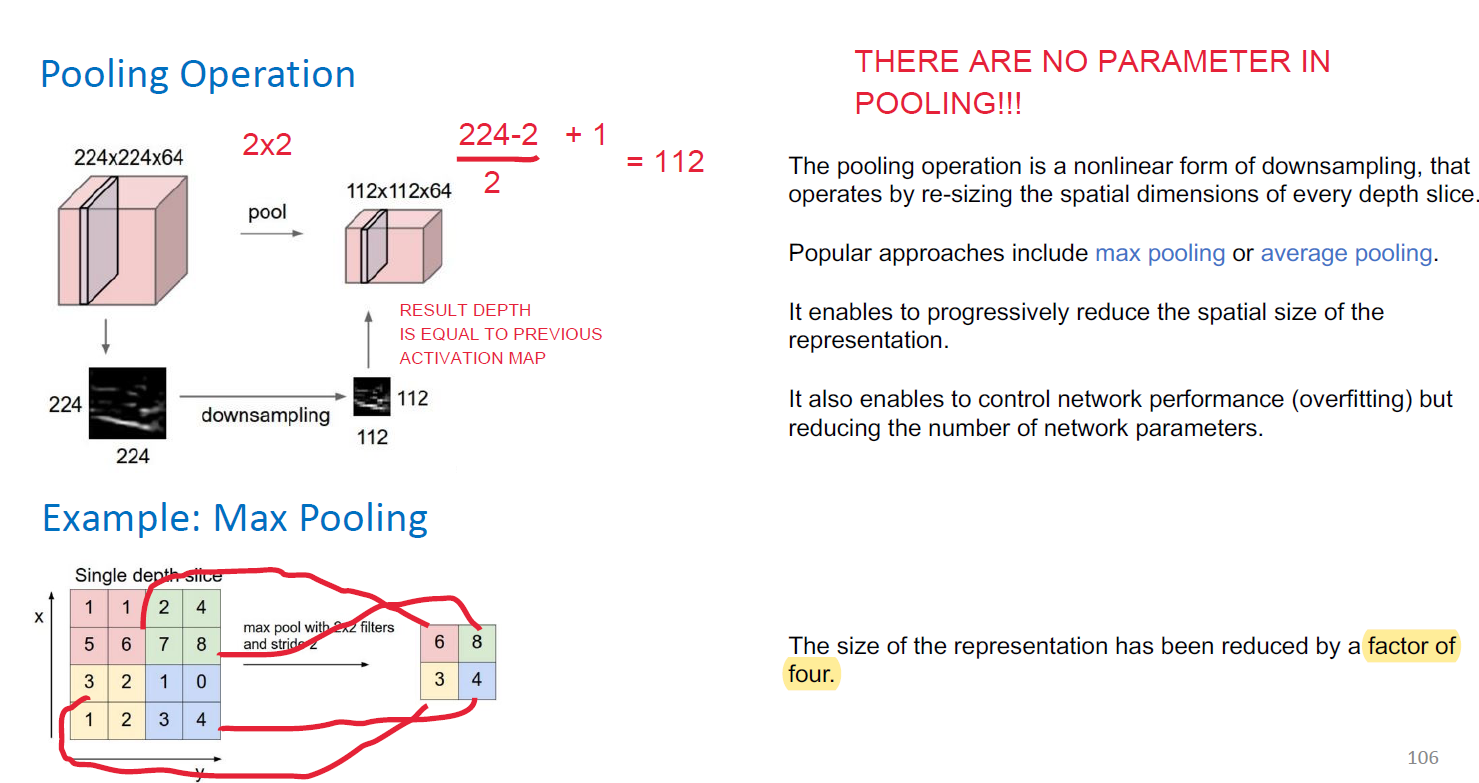

## Objectives

The first step in this project is to retrieve the dataset. The model needs to be trained on the DIVerse 2K resolution high-quality images 1 which provide both high and low-resolution images.

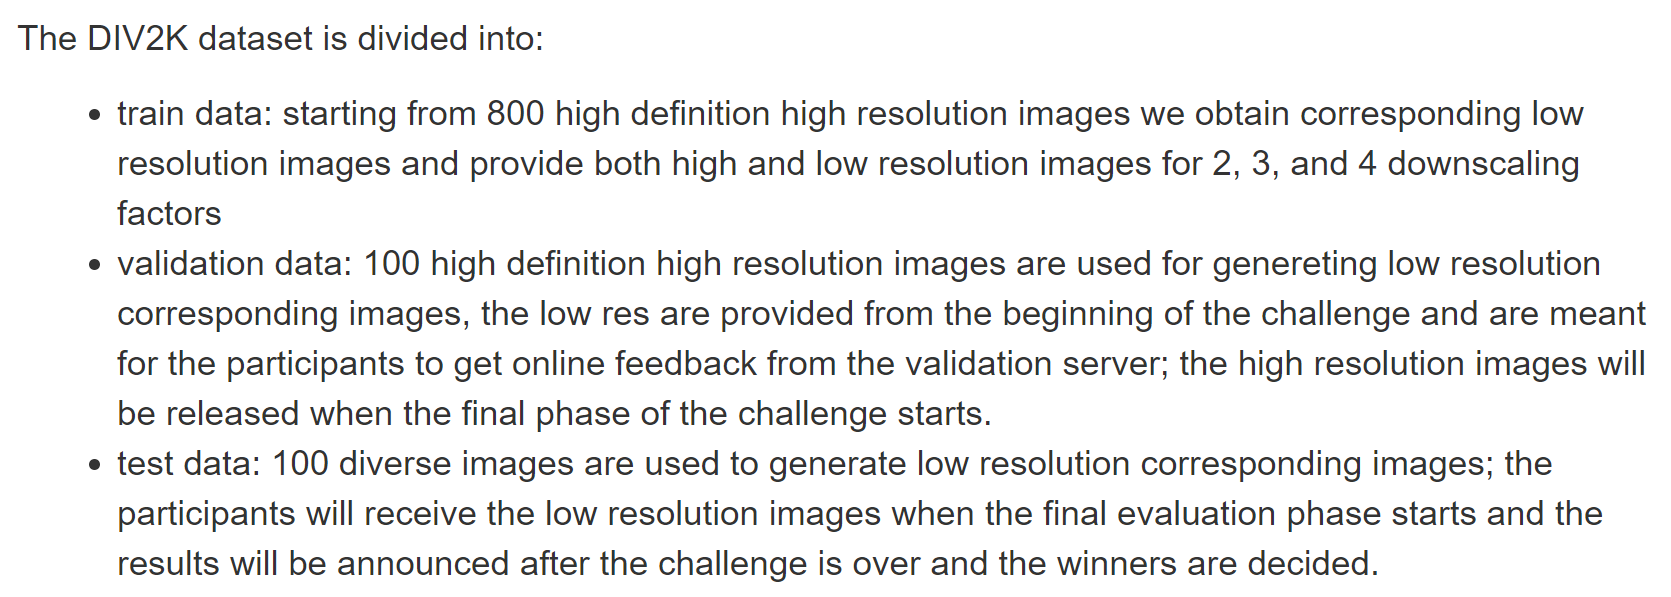

# Imports

In [1]:
import cv2 # computer vision librart
import os  # libray to work with paths and systems
from tqdm.notebook import tqdm # progress bar for jupyter notebooks
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import gc
from skimage.metrics import structural_similarity as ssim

# DATA


Before importing data make sure project has following structure  
[link to data folder](https://vub-my.sharepoint.com/:f:/g/personal/andrzej_krzysztof_pietrusiak_vub_be/Epf4LoQX_D9Euude-yENLmgBRVpu0VFMeMONZA9vmfUJXQ)

<pre>
project folder:  
│  
│── main.ipynb  
│   
└───data    
    ├───DIV2K_train_HR/
    ├───DIV2K_valid_HR/
    ├───DIV2K_train_LR_bicubic/
    └───DIV2K_valid_LR_bicubic/
</pre>

## Identify which images to read (based on size) 

In [3]:
PATH_TRAIN_HR = "./data/DIV2K_train_HR/" # Esteban,Amna, don't change that, just add shortcut in ur drives, as shown above
sizes={}
for file in tqdm(  os.listdir(PATH_TRAIN_HR)  ):
    image = cv2.imread(PATH_TRAIN_HR + '/' + file)
    if image.shape in sizes.keys():
        sizes[image.shape]+=1
    else:
        sizes[image.shape]=1

  0%|          | 0/800 [00:00<?, ?it/s]

In [4]:
N=5 # N most common sizes to show
sorted_sizes= list(  sorted(sizes.items(), key=lambda item: item[1],  reverse=True)  )
print("N=",N," most common image sizes in train set:\n")
print(*sorted_sizes[:N], sep='\n')

N= 5  most common image sizes in train set:

((1356, 2040, 3), 429)
((2040, 1356, 3), 49)
((1536, 2040, 3), 48)
((1368, 2040, 3), 28)
((1152, 2040, 3), 20)


# DATA, trainset
## Read images of the most common size into the memory

In [5]:
SELECTED_SIZES=(1356, 2040, 3)   # DEfine size of image to read

### Reading HR images, saving info about their IDs

In [6]:
img_HR_ids=[]
img_HR=[]
for file in tqdm(   os.listdir(PATH_TRAIN_HR)   ):
    img_tmp = cv2.imread(PATH_TRAIN_HR + '/' + file)
    if img_tmp.shape == SELECTED_SIZES:
        img_id= (int(file.split('.')[0])) # number from name convertet into int
        img_HR_ids.append(img_id)
        img_HR.append(img_tmp)
print("Sucess, ", len(img_HR), "High resulution images were loaded to memory")


  0%|          | 0/800 [00:00<?, ?it/s]

Sucess,  429 High resulution images were loaded to memory


#### Reading LR images, aligning thier order with HR images read previously

In [9]:
PATH_TRAIN_LR = "./data/DIV2K_train_LR_bicubic/X2"  
img_LR_dissaligned={}
for file in tqdm(  os.listdir(PATH_TRAIN_LR)  ,desc="Reading LR images"):
  img_tmp_id=int(file.split('x')[0] )
  if img_tmp_id in img_HR_ids: 
    img_LR_dissaligned[img_tmp_id]=  cv2.imread(PATH_TRAIN_LR + '/' + file)

img_LR=[]
for id_HR in tqdm(  img_HR_ids  ,desc="Aligning LR images to HR images"):
  img_LR.append(img_LR_dissaligned[id_HR])

print("Sucess, ", len(img_LR), "Low resulution images were loaded to memory, and aligned with HR images")

Reading LR images:   0%|          | 0/800 [00:00<?, ?it/s]

Aligning LR images to HR images:   0%|          | 0/429 [00:00<?, ?it/s]

Sucess,  429 Low resulution images were loaded to memory, and aligned with HR images


## convert images to numpy

In [10]:
img_lr= np.array(img_LR)
img_hr= np.array(img_HR)

## Saving data for later reuse

In [11]:
with open('./data/PICKLED/img_lr.pickle', 'wb') as handle:
    pickle.dump(img_lr, handle)
    print("img_lr pickled")
with open('./data/PICKLED/img_hr.pickle', 'wb') as handle:
    pickle.dump(img_hr, handle)
    print("img_hr pickled")

# DATA Validation set
## Identify sizes in validation set and display N most common

In [54]:
PATH_VALID_HR = "./data/DIV2K_valid_HR/DIV2K_valid_HR" # Esteban,Amna, don't change that, just add shortcut in ur drives, as shown above
sizes_valid={}
for file in tqdm(  os.listdir(PATH_VALID_HR)  ):
    image = cv2.imread(PATH_VALID_HR + '/' + file)
    if image.shape in sizes_valid.keys():
        sizes_valid[image.shape]+=1
    else:
        sizes_valid[image.shape]=1

N=5 # N most common sizes to show
sorted_valid_sizes= list(  sorted(sizes_valid.items(), key=lambda item: item[1],  reverse=True)  )
print("N=",N," most common image sizes in validation set:\n")
print(*sorted_valid_sizes[:N], sep='\n')

  0%|          | 0/100 [00:00<?, ?it/s]

N= 5  most common image sizes in validation set:

((1356, 2040, 3), 53)
((1536, 2040, 3), 13)
((2040, 1356, 3), 7)
((1152, 2040, 3), 3)
((1284, 2040, 3), 3)


Fortunately (1356, 2040, 3) is also most popular in validation set

## Reading HR validation images

In [56]:
SELECTED_SIZES=(1356, 2040, 3)
img_HR_valid_ids=[]
img_HR_valid=[]
for file in tqdm(   os.listdir(PATH_VALID_HR)   ):
    img_tmp = cv2.imread(PATH_VALID_HR + '/' + file)
    if img_tmp.shape == SELECTED_SIZES:
        img_id= (int(file.split('.')[0])) # number from name convertet into int
        img_HR_valid_ids.append(img_id)
        img_HR_valid.append(img_tmp)
print("Sucess, ", len(img_HR_valid), "High resulution Validation images were loaded to memory")

  0%|          | 0/100 [00:00<?, ?it/s]

Sucess,  53 High resulution Validation images were loaded to memory


## Reading LR validation images

In [59]:
PATH_VALID_LR = "./data/DIV2K_valid_LR_bicubic/X2"  
img_LR_dissaligned={}
for file in tqdm(  os.listdir(PATH_VALID_LR)  ,desc="Reading LR images"):
  img_tmp_id=int(file.split('x')[0] )
  if img_tmp_id in img_HR_valid_ids:
    img_LR_dissaligned[img_tmp_id]=  cv2.imread(PATH_VALID_LR + '/' + file)

img_LR_valid=[]
for id_HR in tqdm(  img_HR_valid_ids  ,desc="Aligning LR images to HR images"):
  img_LR_valid.append(img_LR_dissaligned[id_HR])

print("Sucess, ", len(img_LR_valid), "Low resulution images were loaded to memory, and aligned with HR images")

Reading LR images:   0%|          | 0/100 [00:00<?, ?it/s]

Aligning LR images to HR images:   0%|          | 0/53 [00:00<?, ?it/s]

Sucess,  53 Low resulution images were loaded to memory, and aligned with HR images


## Convert validation images to numpy

In [62]:
img_lr_valid= np.array(img_LR_valid)
img_hr_valid= np.array(img_HR_valid)

## Save validation images for later reuse

In [63]:
with open('./data/PICKLED/img_lr_valid.pickle', 'wb') as handle:
    pickle.dump(img_lr_valid, handle)
    print("img_lr_valid pickled")
with open('./data/PICKLED/img_hr_valid.pickle', 'wb') as handle:
    pickle.dump(img_hr_valid, handle)
    print("img_hr_valid pickled")

img_lr_valid pickled
img_hr_valid pickled


# DATA, Load pickled arrays

In [8]:
start = time.time()
img_lr= pickle.load( open( "./data/PICKLED/img_lr.pickle", "rb" ) )
img_hr= pickle.load( open( "./data/PICKLED/img_hr.pickle", "rb" ) )
end = time.time()

print("img_lr occupies:", int(img_lr.nbytes/1e6), "MB in memory", "img_lr shape:", img_lr.shape)
print("img_hr occupies:", int(img_hr.nbytes/1e6), "MB in memory", "img_hr shape:", img_hr.shape)
print("time to unpickle: %.1fs" % (end-start))

img_lr occupies: 890 MB in memory img_lr shape: (429, 678, 1020, 3)
img_hr occupies: 3560 MB in memory img_hr shape: (429, 1356, 2040, 3)
time to unpickle: 9.5s


In [17]:
start = time.time()
img_lr_valid = pickle.load( open( "./data/PICKLED/img_lr_valid.pickle", "rb" ) )
img_hr_valid= pickle.load( open( "./data/PICKLED/img_hr_valid.pickle", "rb" ) )
end = time.time()

print("img_lr occupies:", int(img_lr_valid.nbytes/1e6), "MB in memory", "img_lr_valid shape:", img_lr_valid.shape)
print("img_hr occupies:", int(img_hr_valid.nbytes/1e6), "MB in memory", "img_hr_valid shape:", img_hr_valid.shape)
print("time to unpickle: %.1fs" % (end-start))

img_lr occupies: 109 MB in memory img_lr_valid shape: (53, 678, 1020, 3)
img_hr occupies: 439 MB in memory img_hr_valid shape: (53, 1356, 2040, 3)
time to unpickle: 0.7s


# Down scale images (create new sets with lower resolution)

In [10]:
scale=20
rescaled_in=[]
for img in img_hr:
    resized = cv2.resize(img, (int(img.shape[1]/scale), int(img.shape[0]/scale)), interpolation = cv2.INTER_AREA)
    rescaled_in.append(resized)
rescaled_in= np.array(rescaled_in)

In [11]:
scale=10
rescaled_out=[]
for img in img_hr:
    resized = cv2.resize(img, (int(img.shape[1]/scale), int(img.shape[0]/scale)), interpolation = cv2.INTER_AREA)
    rescaled_out.append(resized)
rescaled_out= np.array(rescaled_out)

In [12]:
with open('./data/PICKLED/rescaled_20.pickle', 'wb') as handle:
    pickle.dump(rescaled_in, handle)
    print("rescaled_in pickled")
with open('./data/PICKLED/rescaled_10.pickle', 'wb') as handle:
    pickle.dump(rescaled_out, handle)
    print("rescaled_out pickled")

rescaled_in pickled
rescaled_out pickled


## Read rescaled_20 and rescaled_10

In [7]:
img_lr= pickle.load( open( "./data/PICKLED/img_lr.pickle", "rb" ) )
rescaled_out= pickle.load( open( "./data/PICKLED/rescaled_10.pickle", "rb" ) )


## Plot 10 images of train set to check alignment (works also with unpickled)

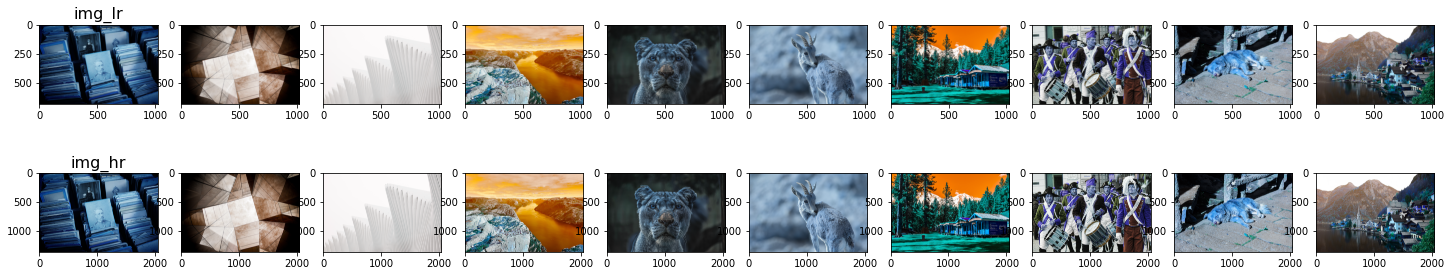

In [40]:
fig, axs = plt.subplots(2,10, figsize=(25,5))
for i, ax in enumerate(axs[0]):
  ax.imshow(img_lr[i])
axs[0,0].set_title("img_lr",fontsize=16)

for i, ax in enumerate(axs[1]):
  ax.imshow(img_hr[i])
axs[1,0].set_title("img_hr",fontsize=16)
pass

## Plot 10 images of validation set to check alignment

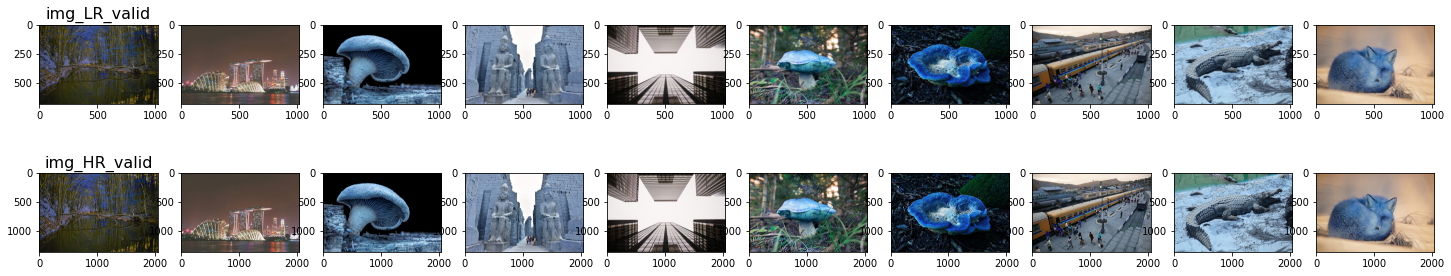

In [19]:
fig, axs = plt.subplots(2,10, figsize=(25,5))
for i, ax in enumerate(axs[0]):
  ax.imshow(img_lr_valid[i])
axs[0,0].set_title("img_LR_valid",fontsize=16)

for i, ax in enumerate(axs[1]):
  ax.imshow(img_hr_valid[i])
axs[1,0].set_title("img_HR_valid",fontsize=16)
pass

# Normalize image (in np domain)

In [13]:
img_lr_normalized= rescaled_in/ 255.0
img_hr_normalized= rescaled_out/255.0

## Resampling the Low-Resolution Images to 2K to prepare them as INPUT for the CNN

In [14]:
# Upsample the LOW-RES images to given high resolution:
def upscale(lr_images, new_height, new_width):
  resampled_height = new_height
  resampled_width = new_width

  resampled_images = []
  for i in range(len(lr_images)):
    resampled_images.append(cv2.resize(lr_images[i], (resampled_width, resampled_height), interpolation=cv2.INTER_CUBIC))
  
  resampled_images= np.array(resampled_images)
  return resampled_images

In [15]:
# How to use upsampling
lr_upscaled= upscale(img_lr_normalized,new_height=135, new_width=204)

In [19]:
img_hr_normalized[3,:,:,:].shape

(135, 204, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


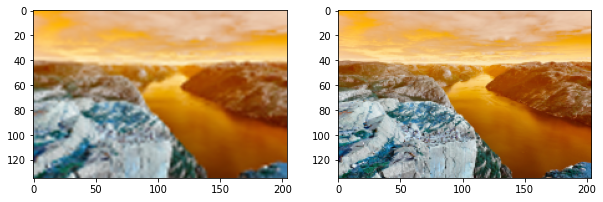

In [21]:
fig, axs= plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(lr_upscaled[3,:,:,:])
axs[1].imshow(img_hr_normalized[3,:,:,:])

# My example


In [22]:
IN= torch.tensor(   np.transpose(lr_upscaled,       (0, 3, 1, 2) )  ).float()
OUT=torch.tensor(   np.transpose(img_hr_normalized, (0, 3, 1, 2) )  ).float()
print(f"{IN.shape=}")
print(f"{OUT.shape=}")
print(f"is dtype ok? {IN.dtype==torch.float32}")

IN.shape=torch.Size([429, 3, 135, 204])
OUT.shape=torch.Size([429, 3, 135, 204])
is dtype ok? True


In [23]:
class StupidModel(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=9, padding= 9//2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [26]:
stupidModel=StupidModel()
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(stupidModel.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(stupidModel.parameters(), lr=0.001)
batch_size=16
running_loss = 0.0
epochs=100
loss_vals=[]
best_epoch=0

stupidModel.train()
for e in tqdm(range(epochs)):
        for i in range(0, len(IN), batch_size):  # loop over the dataset multiple times

                batch_x=  IN[i:i+batch_size].view(-1,3,135,204)
                batch_y= OUT[i:i+batch_size].view(-1,3,135,204)
                
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = stupidModel(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        loss_vals.append(loss.item())
        #print(e, end=" ")

        torch.save(stupidModel.state_dict(), "./models/m"+str(e))

print('Finished Training')


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
haha= stupidModel(IN)

In [179]:
IN_np=IN.numpy()
OUT_np=haha.detach().numpy()

In [182]:
OUT_np.min()

-0.070819706

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


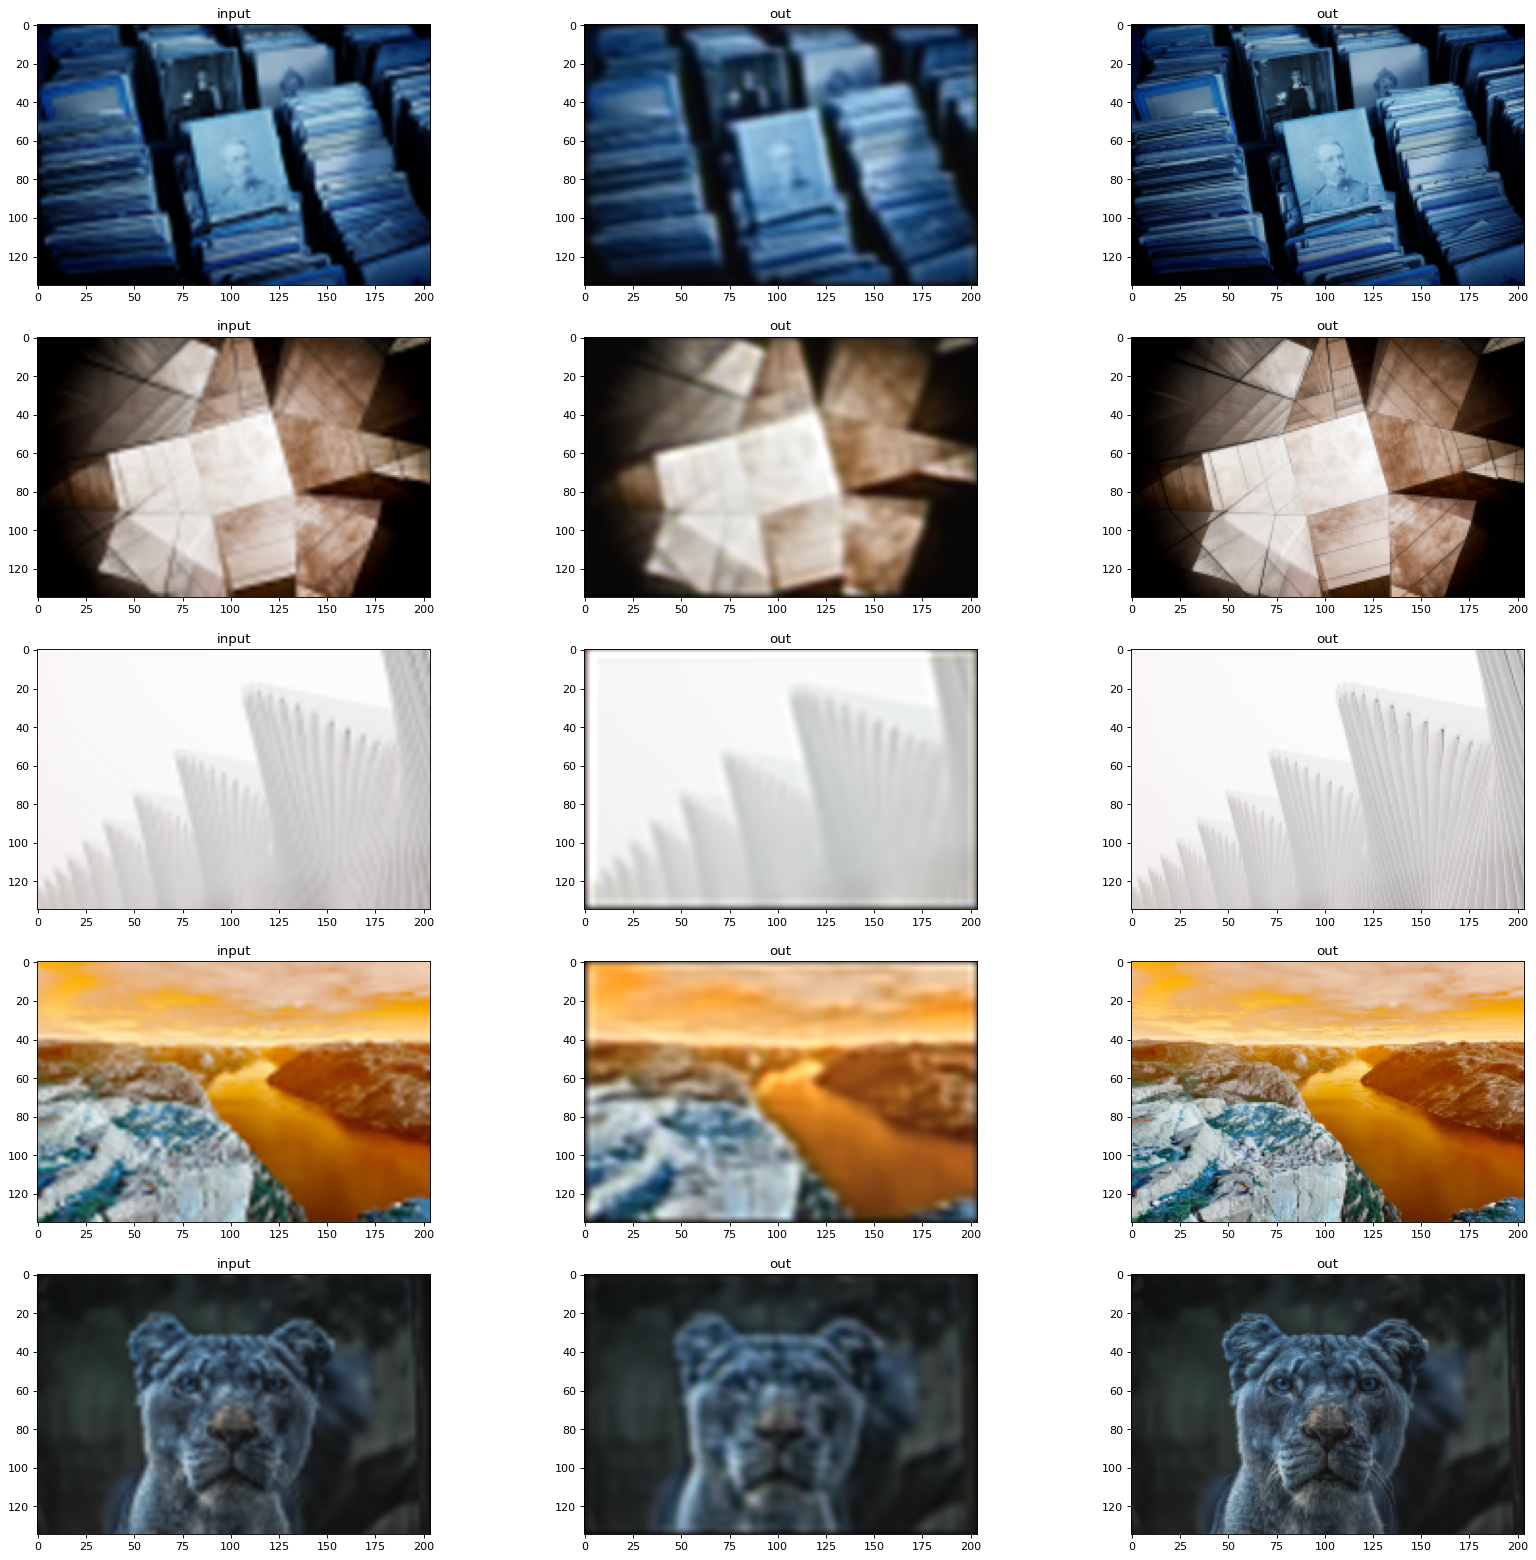

In [180]:
fig, axs = plt.subplots(5,3, figsize=(25,25), dpi=80)
for i, ax in enumerate(axs):
    ax[0].imshow(np.transpose(IN_np[i], (1, 2, 0) ) ); ax[0].set_title("input")
    ax[1].imshow(np.transpose(OUT_np[i], (1, 2, 0) ) ); ax[1].set_title("out")
    ax[2].imshow(np.transpose(OUT[i], (1, 2, 0) ) ); ax[2].set_title("out")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'out')

<Figure size 800x960 with 0 Axes>

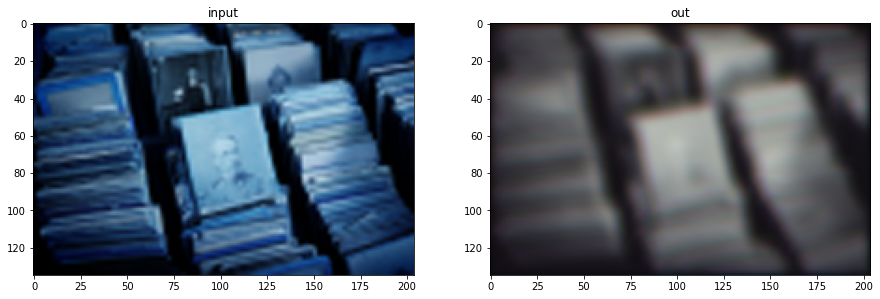

In [130]:
plt.figure(figsize=(10, 12), dpi=80)
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
ax[0].imshow(np.transpose(IN_np[0], (1, 2, 0) ) ); ax[0].set_title("input")
ax[1].imshow(np.transpose(OUT_np[0], (1, 2, 0) ) ); ax[1].set_title("out")

# py torch example

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


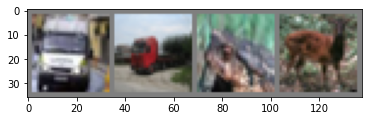

truck truck frog  deer 


In [45]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [42]:
images[0].shape

torch.Size([3, 32, 32])

In [ ]:
plt.imshow(np.transpose(images[0], (1, 2, 0) ) )

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.246
[1,  4000] loss: 1.948
[1,  6000] loss: 1.721
[1,  8000] loss: 1.606
[1, 10000] loss: 1.534
[1, 12000] loss: 1.484
[2,  2000] loss: 1.416
[2,  4000] loss: 1.375
[2,  6000] loss: 1.351
[2,  8000] loss: 1.315
[2, 10000] loss: 1.305
[2, 12000] loss: 1.273
Finished Training


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

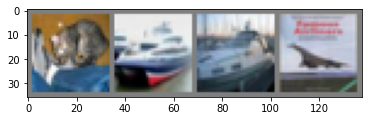

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
outputs = net(images)
outputs.shape

torch.Size([4, 10])

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


# SR CNN Example 

In [19]:
class SRNET(nn.Module):

    def __init__(self, ngpu):
        super(SRNET, self).__init__()

        self.ngpu = ngpu
        self.model = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=9//2),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0//2),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, stride=1, padding=5//2),
          nn.ReLU(),
        )

    def forward(self, input):
        return torch.clamp(self.model(input), min=1e-12, max=1-(1e-12))

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

# My example


Input format

Text(0.5, 1.0, 'input')

<Figure size 800x960 with 0 Axes>

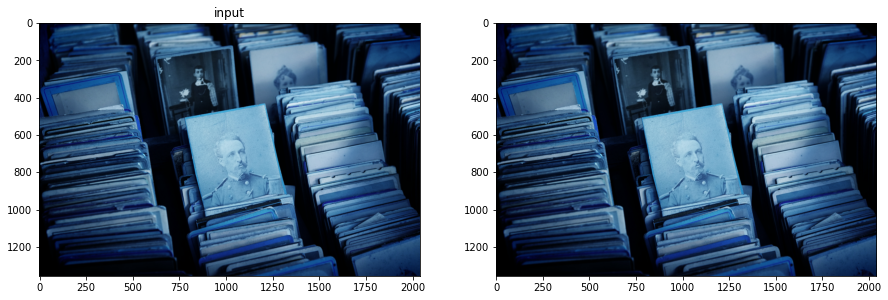

In [72]:
plt.figure(figsize=(10, 12), dpi=80)
plt

fig, ax = plt.subplots(1, 2, figsize=(15, 12))
ax[0].imshow(np.transpose(y, (1, 2, 0) ) ); ax[0].set_title("out")
ax[1].imshow(np.transpose(tensor_lr[0], (1, 2, 0) ) ); ax[0].set_title("input")